# Harry Potter and English Exercises
## Pet-project of Lyalin Dmitriy, Yandex Workshop, summer 2023

![Harry](harry_potter.jpg)

Let's begin with importing dependencies

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import List

## Choosing a literature and creating the vocabulary

Choosing the file paths for all seven books of Harry Potter

In [2]:
file_paths = {}
file_path_base = '/content/drive/MyDrive/yandex_english_project/Harry_Potter_{}.txt'
for i in range(1, 8):
    variable_name = f'file_path_potter_{i}'
    file_path = file_path_base.format(i)
    file_paths[variable_name] = file_path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
file_paths['file_path_potter_1']

'/content/drive/MyDrive/yandex_english_project/Harry_Potter_1.txt'

Ok. Now we tokenize each book on sentences and put it in a dictionary

In [7]:
sentences_harry = {}

for i in range(1, 8):
    if i == 4 or i == 6:
      file_path_potter = file_path_base.format(i)
      with open(file_path_potter, 'r', encoding='latin-1') as file:
        text = file.read()
      sentences = nltk.sent_tokenize(text)
      variable_name = f'sentences_harry_{i}'
      sentences_harry[variable_name] = sentences
    else:
      file_path_potter = file_path_base.format(i)
      with open(file_path_potter, 'r') as file:
        text = file.read()
      sentences = nltk.sent_tokenize(text)
      variable_name = f'sentences_harry_{i}'
      sentences_harry[variable_name] = sentences

In [8]:
len(sentences_harry)

7

Now we want to do a single list with all 7 books sentences

In [9]:
sentences_lists = sentences_harry.values()
all_sentences_harry = [sentence for sentences_list in sentences_lists for sentence in sentences_list]

In [10]:
len(all_sentences_harry)

76083

Wow! We have 76,000 sentences! J.K. Rowling has done an enormous amount of work!

In [11]:
# Print the sentences
for sentence in all_sentences_harry[-5:]:
    print(sentence)

“He’ll be all right,” murmured Ginny.
As Harry looked at her, he lowered his hand absent-mindedly and touched the lightning scar on his forehead.
“I know he will.”
   The scar had not pained Harry for nineteen years.
All was well.
Взято из Флибусты, http://flibusta.net/b/172171


Here we can see there are some russian words in our list, we take them out later

In [12]:
sentences_harry_data = pd.DataFrame(all_sentences_harry)

In [13]:
random_rows = sentences_harry_data.sample(n=20)
print(random_rows)

                                                                                                                                                                                                                                                0
28449                                                                                                                                                                                                      "What do they want photos for, Colin?"
35004                                                                                                                                                                                                                                   Granger."
47040  “Let’s go, then,” said Sirius, clapping Harry on the shoulder and smiling grimly, and before Harry could say anything else, they were heading upstairs, stopping before the heavily chained and bolted front door, surrounded by Weasleys.
34362                           

In [14]:
all_sentences_harry[:3]

["Harry Potter and the Sorcerer's Stone\n\n\nCHAPTER ONE\n\nTHE BOY WHO LIVED\n\nMr. and Mrs. Dursley, of number four, Privet Drive, were proud to say\nthat they were perfectly normal, thank you very much.",
 "They were the last\npeople you'd expect to be involved in anything strange or mysterious,\nbecause they just didn't hold with such nonsense.",
 'Mr. Dursley was the director of a firm called Grunnings, which made\ndrills.']

Now we choose sentences <= 32 words

In [15]:
all_sentences_harry_new = []
word_threshold = 32
# retrieve individual sentences and place them into sentences
# also, let's remove <br /><br /> - this is an HTML tag commonly used to indicate line breaks in web content
for text in tqdm(all_sentences_harry):
    cleaned_text = text.replace('\\', '')
    all_sentences_harry_new.extend(
        [x.lower() for x in sent_tokenize(text.replace('\n', ''),\
                                          language='english') if len(word_tokenize(x)) < word_threshold])

  0%|          | 0/76083 [00:00<?, ?it/s]

In [16]:
all_sentences_harry_new[:2]

["harry potter and the sorcerer's stonechapter onethe boy who livedmr.",
 'and mrs. dursley, of number four, privet drive, were proud to saythat they were perfectly normal, thank you very much.']

In [49]:
print("Number of all sentences:", len(all_sentences_harry_new))

Number of all sentences: 65139


Now we will calculate the frequency of words in all the Harry Potter books

In [18]:
words = Counter()
for sentence in tqdm(all_sentences_harry_new):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/65139 [00:00<?, ?it/s]

In [19]:
len(words)

30077

I mentioned that in the 1st book we have about 4000 words, but in all 7 books we have 30000! It's very interesting, i guess that the last books are harder for reading than the first books.

In [57]:
first_30 = words.most_common(30)
# Print the first 30 key-value pairs
for word, count in first_30:
    print(word, count)

. 53011
, 50667
the 28853
'' 18252
`` 17139
to 15442
and 14482
he 13443
harry 12146
a 11998
of 11513
said 11027
was 9635
you 9584
? 8965
“ 8961
it 8872
i 8795
his 8404
” 8109
in 7170
’ 6374
! 6031
's 5822
that 5691
had 5552
at 5444
ron 4328
as 4251
him 4176


Interesting. We see many prepositions, articles, pronouns, and conjunctions, but the name Harry is still in the 9th place, and Ron is in the 28th. Wow!

Now we take 25k words of 30k words to exclude rare words and russian words from our vocabulary for training language models

In [20]:
vocab = set()
vocab_size = 25000
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
for word, cnt in words.most_common()[:vocab_size]:
  vocab.add(word)

In [21]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [58]:
print("All words in vocabulary:", len(vocab))

All words in vocabulary: 25004


In [23]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

## Doing some preparations for models training

After that we code class WordDataset, add some padding to batch etc.

In [24]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [25]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

Now lets split out sentences to train, eval and test sentences. We will use test sentences to measure perplexity

In [26]:
train_sentences, eval_sentences = train_test_split(all_sentences_harry_new, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [27]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

Train cycle

In [28]:
def train_model(net, hidden_dim, vocab_size, epochs, train_dataloader,\
                eval_dataloader, lr=0.001, rnn=nn.RNN, num_layers=1):

    model = net(hidden_dim=hidden_dim, vocab_size=vocab_size, layer=rnn,\
                num_layers=num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses_train = []
    perplexities_train = []
    losses_val = []
    perplexities_val = []

    for epoch in range(epochs):
        epoch_losses = []
        avg_loss_val = []
        perplexity = []
        perplexity_v = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            perplexity.append(torch.exp(loss).item())

        losses_train.append(sum(epoch_losses) / len(epoch_losses))
        perplexities_train.append(sum(perplexity) / len(perplexity))

        model.eval()
        with torch.no_grad():
            for batch in eval_dataloader:
                logits_val = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
                loss_val = criterion(logits_val, batch['target_ids'].flatten())
                avg_loss_val.append(loss_val.item())
                perplexity_v.append(torch.exp(loss_val).item())

        losses_val.append(sum(avg_loss_val) / len(avg_loss_val))
        perplexities_val.append(sum(perplexity_v) / len(perplexity_v))

    return (losses_train, losses_val, perplexities_train, perplexities_val, model)

Lets code LanguageModel class. We will use simple models for our future app on Streamlit

In [29]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, layer=nn.RNN, num_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = layer(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [30]:
def plot_all(losses_tr, losses_val, perplexities_tr, perplexities_val):
  fig, axes = plt.subplots(2, 2, figsize=(8, 8))

  # Losses
  axes[0, 0].plot(np.arange(len(losses_tr)), losses_tr)
  axes[0, 0].set_title('Train Losses')
  axes[0, 0].set_xlabel('Epoch')

  axes[0, 1].plot(np.arange(len(losses_val)), losses_val)
  axes[0, 1].set_title('Validation Losses')
  axes[0, 1].set_xlabel('Epoch')

  # Perplexity
  axes[1, 0].plot(np.arange(len(perplexities_tr)), perplexities_tr)
  axes[1, 0].set_title('Train Perplexity')
  axes[1, 0].set_xlabel('Epoch')

  axes[1, 1].plot(np.arange(len(perplexities_val)), perplexities_val)
  axes[1, 1].set_title('Validation Perplexity')
  axes[1, 1].set_xlabel('Epoch')

  plt.tight_layout()
  plt.show()

And in the end lets code function for sentence generating

In [31]:
def generate_sequence (model, starting_seq: str, max_seq_len: int = 256) -> str:
  device = 'cpu'
  model = model.to(device)
  input_ids = [word2ind['<bos>']] + [
    word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
  input_ids = torch.LongTensor(input_ids).to(device)
  model.eval()
  with torch.no_grad():
    for i in range(max_seq_len):
      next_char_distribution = model(input_ids)[-1]
      next_char = next_char_distribution.squeeze().argmax()
      input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])
      if next_char.item() == word2ind['<eos>']:
        break
  words = ' '.join([ind2word.get(idx.item(), '<unk>') for idx in input_ids])
  return words

## Experiment 1. We use simple 1-layer RNN here

In [35]:
losses_tr_1, losses_val_1, perplexities_tr_1, perplexities_val_1, model_1 =\
train_model(LanguageModel, hidden_dim=256, vocab_size=len(vocab), epochs=7,\
             train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, lr=0.001, num_layers=1)

Training epoch 0::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/408 [00:00<?, ?it/s]

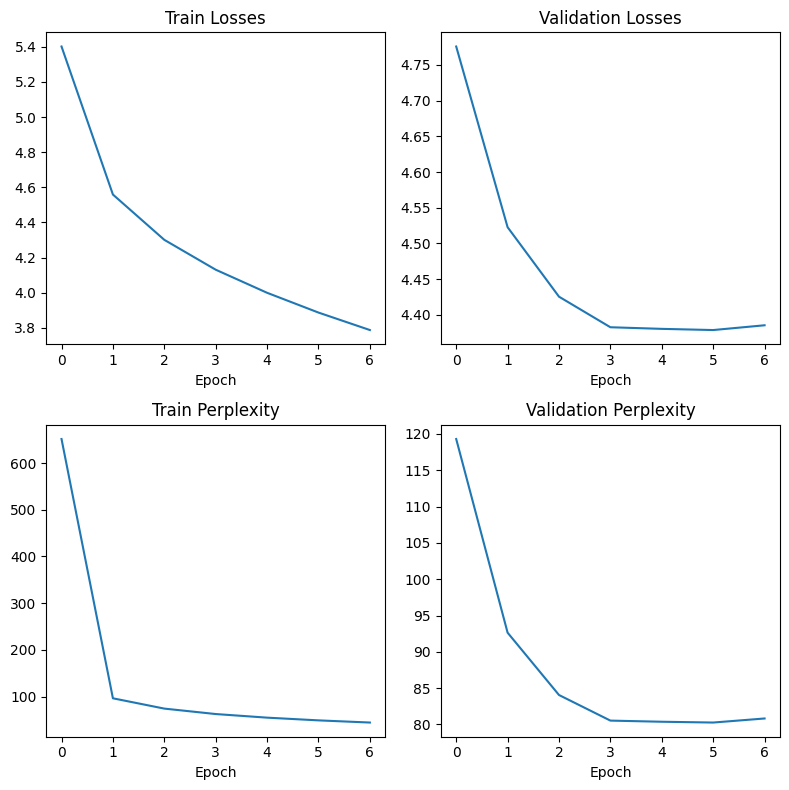

Perplexity on test:  83


In [36]:
plot_all(losses_tr_1, losses_val_1, perplexities_tr_1, perplexities_val_1)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
print('Perplexity on test: ', round(evaluate(model_1, criterion, test_dataloader)))

83 perplexity, not bad. Then i use this model with 'imdb dataset', the perplexity was around 100.

In [37]:
# Save the model
torch.save(model_1.state_dict(), '/content/drive/MyDrive/yandex_english_project/model_1.pth')

In [38]:
# # Load the model
# model_1 = LanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=1)
# model_1.load_state_dict(torch.load('/content/drive/MyDrive/yandex_english_project/model_1.pth'))
# model_1.eval()

In [39]:
(
generate_sequence (model_1, starting_seq='harry was '),
generate_sequence (model_1, starting_seq='it was owl '),
generate_sequence (model_1, starting_seq='quidditch is '),
generate_sequence (model_1, starting_seq='thanks to her '),
generate_sequence (model_1, starting_seq='hermione should be ')
)

("<bos> harry was n't there . <eos>",
 '<bos> it was owl , but he was not sure he had been in the house . <eos>',
 "<bos> quidditch is not a good idea , '' said harry . <eos>",
 "<bos> thanks to her , '' said harry . <eos>",
 '<bos> hermione should be a little chat . <eos>')

The second sentence is funny: it's Schrödinger's owl. Ahaha.

Now lets generate questions

In [40]:
(
generate_sequence(model_1, starting_seq='is harry going '),
generate_sequence(model_1, starting_seq='was it me '),
generate_sequence(model_1, starting_seq='does quidditch '),
generate_sequence(model_1, starting_seq='who did the '),
generate_sequence(model_1, starting_seq='should hermione be ')
)

('<bos> is harry going to be a bit of a lot of magic . <eos>',
 "<bos> was it me , harry , '' said harry . <eos>",
 '<bos> does quidditch have been a bit of a lot of magic . <eos>',
 '<bos> who did the order of the phoenix ? <eos>',
 '<bos> should hermione be able to get rid of the castle . <eos>')

We can see a little problem with "?" signs.

### Experiment 2. Lets take LSTM layer

In [41]:
losses_tr_exp_2, losses_val_exp_2, perplexities_tr_exp_2, perplexities_val_exp_2, model_2 =\
train_model(LanguageModel, hidden_dim=256, vocab_size=len(vocab), epochs=7,\
            train_dataloader=train_dataloader, eval_dataloader=eval_dataloader,\
            lr=0.001, rnn=nn.LSTM, num_layers=1)

Training epoch 0::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/408 [00:00<?, ?it/s]

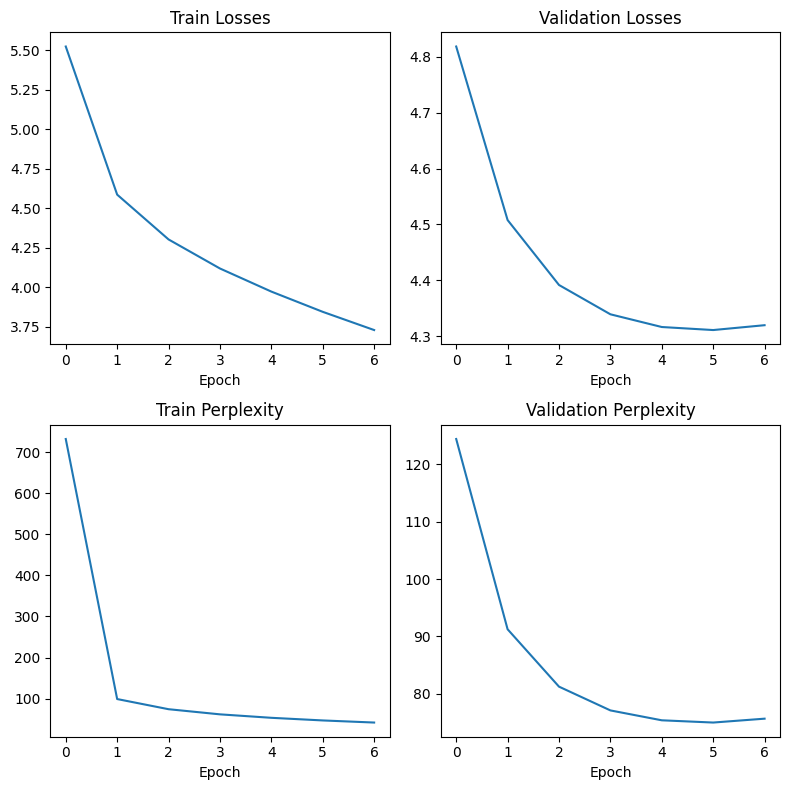

Perplexity on test:  78


In [42]:
plot_all(losses_tr_exp_2, losses_val_exp_2, perplexities_tr_exp_2, perplexities_val_exp_2)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
print('Perplexity on test: ', round(evaluate(model_2, criterion, test_dataloader)))

78. Wow. It's much better!

In [43]:
(
generate_sequence (model_2, starting_seq='harry was '),
generate_sequence (model_2, starting_seq='it was owl '),
generate_sequence (model_2, starting_seq='quidditch is '),
generate_sequence (model_2, starting_seq='thanks to her '),
generate_sequence (model_2, starting_seq='hermione should be ')
)

('<bos> harry was not sure he had been in the world . <eos>',
 '<bos> it was owl , but he was not sure he had been in the world . <eos>',
 "<bos> quidditch is , '' said harry . <eos>",
 "<bos> thanks to her , i 'm not sure you 'd be able to get rid of the school . <eos>",
 '<bos> hermione should be in the room of requirement , ” said harry . <eos>')

Now in the 1st sentence we could see Harry Schrödinger.

In [44]:
(
generate_sequence(model_2, starting_seq='is harry going '),
generate_sequence(model_2, starting_seq='was it me '),
generate_sequence(model_2, starting_seq='does quidditch '),
generate_sequence(model_2, starting_seq='who did the '),
generate_sequence(model_2, starting_seq='should hermione be ')
)

('<bos> is harry going to be a bit of a bit of a lot of magic . <eos>',
 '<bos> was it me ? <eos>',
 "<bos> does quidditch match ? '' <eos>",
 '<bos> who did the matter ? <eos>',
 '<bos> should hermione be a bit of a bit of a bit of a <unk> ” “ i ’ ve been able to get rid of the death eaters , ” said harry . <eos>')

In [45]:
# Save the model
torch.save(model_2.state_dict(), '/content/drive/MyDrive/yandex_english_project/model_2.pth')

In [46]:
# # Load the model
# model_2 = LanguageModel(hidden_dim=256, vocab_size=len(vocab), rnn=nn.LSTM, num_layers=1)
# model_2.load_state_dict(torch.load('/content/drive/MyDrive/yandex_english_project/model_2.pth'))
# model_2.eval()

### Experiment 3. LSTM and 3 layers

In [47]:
losses_tr_exp_3, losses_val_exp_3, perplexities_tr_exp_3, perplexities_val_exp_3, model_3 =\
train_model(LanguageModel, hidden_dim=256, vocab_size=len(vocab), epochs=7,\
             train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, lr=0.001, rnn=nn.LSTM, num_layers=3)

Training epoch 0::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/408 [00:00<?, ?it/s]

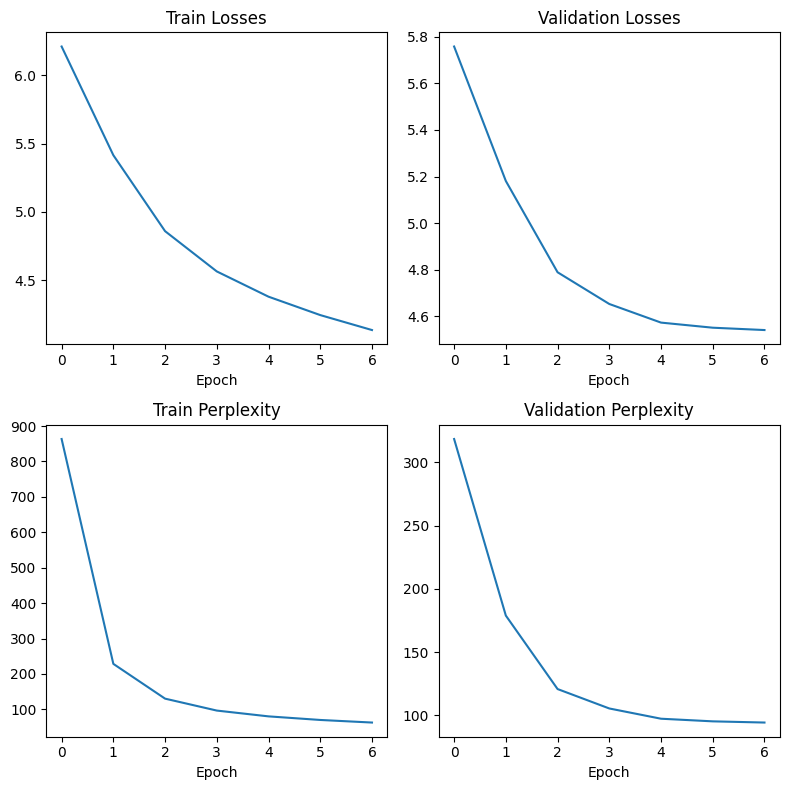

Perplexity on test:  96


In [60]:
plot_all(losses_tr_exp_3, losses_val_exp_3, perplexities_tr_exp_3, perplexities_val_exp_3)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
print('Perplexity on test: ', round(evaluate(model_3, criterion, test_dataloader)))

Perplexity (96) has significantly decreased. I wonder why? Could it be due to the small vocabulary size for such a large model?

We can note that on the 7th epoch, this model does not overfit compared to the models from experiments 1 and 2.

In [61]:
(
generate_sequence (model_3, starting_seq='harry was '),
generate_sequence (model_3, starting_seq='it was owl '),
generate_sequence (model_3, starting_seq='quidditch is '),
generate_sequence (model_3, starting_seq='thanks to her '),
generate_sequence (model_3, starting_seq='hermione should be ')
)

('<bos> harry was still a little , and he had been a few of the moment . <eos>',
 '<bos> it was owl , and he had been a few of the moment . <eos>',
 '<bos> quidditch is not a bit of a few days . <eos>',
 "<bos> thanks to her , '' said harry . <eos>",
 '<bos> hermione should be a bit of a few days . <eos>')

In [62]:
(
generate_sequence(model_3, starting_seq='is harry going '),
generate_sequence(model_3, starting_seq='was it me '),
generate_sequence(model_3, starting_seq='does quidditch '),
generate_sequence(model_3, starting_seq='who did the '),
generate_sequence(model_3, starting_seq='should hermione be ')
)

('<bos> is harry going to be able to get to the ministry of magic . <eos>',
 '<bos> was it me , i was not to be able to be able to get up to the castle . <eos>',
 "<bos> does quidditch know that ? '' <eos>",
 '<bos> who did the ministry , i ’ ve been able to be able to get to the ministry of magic . <eos>',
 '<bos> should hermione be going to be able to get to the end of the castle . <eos>')

In [63]:
# Save the model
torch.save(model_3.state_dict(), '/content/drive/MyDrive/yandex_english_project/model_3.pth')

In [64]:
# # Load the model
# model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), rnn=nn.LSTM, num_layers=3)
# model.load_state_dict(torch.load('/content/drive/MyDrive/yandex_english_project/model_3.pth'))
# model.eval()

### Experiment 4. No dropout, hidden_dim=512, 3 layers

In [65]:
class LanguageModel_no_drop(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, layer=nn.RNN, num_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = layer(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.linear(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

Lets try to train this model with 9 epochs

In [67]:
losses_tr_exp_4, losses_val_exp_4, perplexities_tr_exp_4, perplexities_val_exp_4, model_4 =\
train_model(LanguageModel_no_drop, hidden_dim=512, vocab_size=len(vocab), epochs=9,\
             train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, lr=0.001, rnn=nn.LSTM, num_layers=3)

Training epoch 0::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/408 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/408 [00:00<?, ?it/s]

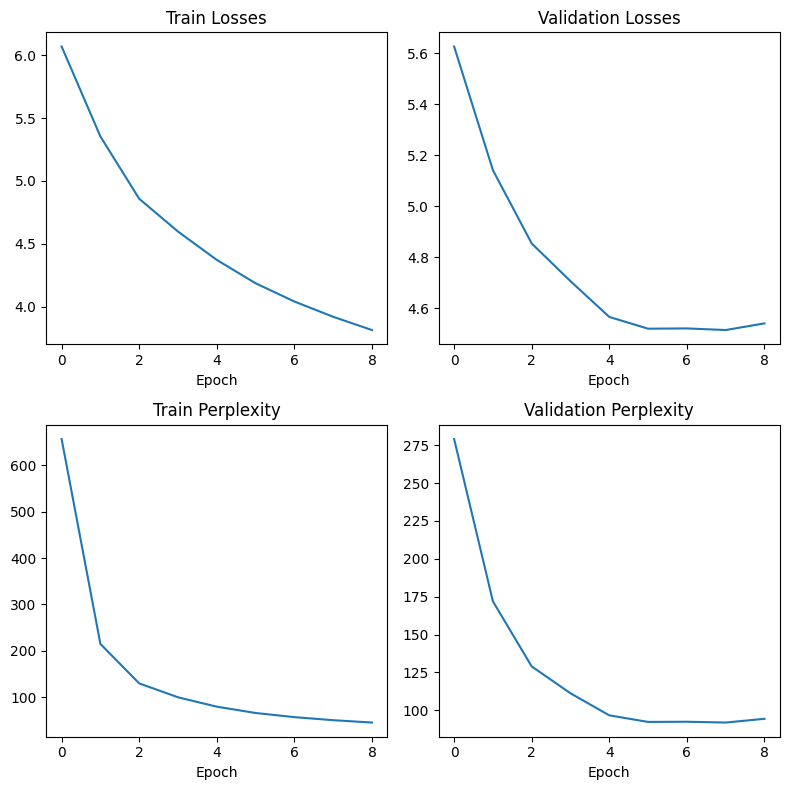

Perplexity on test:  97


In [68]:
plot_all(losses_tr_exp_4, losses_val_exp_4, perplexities_tr_exp_4, perplexities_val_exp_4)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
print('Perplexity on test: ', round(evaluate(model_4, criterion, test_dataloader)))

97. Not bad. But as we can see our model_4 is a bit overfitting at 8-9th epoch.

In [69]:
(
generate_sequence (model_4, starting_seq='harry was '),
generate_sequence (model_4, starting_seq='it was owl '),
generate_sequence (model_4, starting_seq='quidditch is '),
generate_sequence (model_4, starting_seq='thanks to her '),
generate_sequence (model_4, starting_seq='hermione should be ')
)

('<bos> harry was not sure he had been in the forest . <eos>',
 '<bos> it was owl and a loud , <unk> and <unk> , <unk> and <unk> . <eos>',
 "<bos> quidditch is a bit of a jiffy , and i 'm not to be able to get rid of the school . <eos>",
 "<bos> thanks to her , i 'm not to be able to get rid of the school . <eos>",
 '<bos> hermione should be able to be able to be able to contain a single <unk> . <eos>')

In [70]:
(
generate_sequence(model_4, starting_seq='is harry going '),
generate_sequence(model_4, starting_seq='was it me '),
generate_sequence(model_4, starting_seq='does quidditch '),
generate_sequence(model_4, starting_seq='who did the '),
generate_sequence(model_4, starting_seq='should hermione be ')
)

('<bos> is harry going to be able to get rid of the school ? <eos>',
 '<bos> was it me to do . <eos>',
 "<bos> does quidditch matter that you 're going to be able to get rid of the school . <eos>",
 '<bos> who did the dursleys be much of the world ? <eos>',
 '<bos> should hermione be able to be able to get up to the castle . <eos>')

In [71]:
# Save the model
torch.save(model_4.state_dict(), '/content/drive/MyDrive/yandex_english_project/model_4.pth')

In [72]:
# # Load the model
# model_4 = LanguageModel_no_drop(hidden_dim=512, vocab_size=len(vocab), rnn=nn.LSTM, num_layers=3)
# model_4.load_state_dict(torch.load('/content/drive/MyDrive/yandex_english_project/model_2.pth'))
# model_4.eval()

## Excercise 1. A simple one

In [73]:
sentences_harry_data.columns = ['sentences']
sentences_harry_data.head(2)

,sentences
0,"Harry Potter and the Sorcerer's Stone\n\n\nCHAPTER ONE\n\nTHE BOY WHO LIVED\n\nMr. and Mrs. Dursley, of number four, Privet Drive, were proud to say\nthat they were perfectly normal, thank you very much."
1,"They were the last\npeople you'd expect to be involved in anything strange or mysterious,\nbecause they just didn't hold with such nonsense."


Ok. Lets code the function which will be check if len(sentences) >= 6, it will rendomly get 3-5 first words from the original sentence and generate new sentence

In [74]:
import random

def generate_random_sequence(model, sentences_df):
    # Select a random sentence from the dataframe with a length of 6 or more words
    candidate_sentences = sentences_df[sentences_df['sentences'].str.split().apply(len) >= 6]
    random_sentence = random.choice(candidate_sentences['sentences'])

    # Convert the sentence to lowercase
    random_sentence = random_sentence.lower()

    # Split the sentence into words
    words = random_sentence.split()

    # Select the first 3-5 words from the sentence
    num_words = random.randint(3, min(5, len(words)))
    selected_words = words[:num_words]

    # Construct the starting sequence by joining the selected words
    starting_sequence = ' '.join(selected_words)

    # Generate a sequence using the model and the starting sequence
    generated_sequence = generate_sequence(model, starting_seq=starting_sequence)

    # Remove special tokens from the generated sequence
    generated_sequence = generated_sequence.replace('<bos>', '').replace('<eos>', '').replace('<unk>', '')

    return random_sentence, generated_sequence

In [79]:
generate_random_sequence(model_1, sentences_harry_data)

('"i think i\'ll go to bed and -"\n\n"you will not," snapped mrs. weasley.',
 " `` i think i 'll go on , '' said harry . ")

In [80]:
generate_random_sequence(model_2, sentences_harry_data)

('he hoped, when he possessed you briefly a short while ago, that i would sacrifice you in the hope of killing him.',
 ' he hoped , when he possessed he had to be in the middle of the forest . ')

In [81]:
generate_random_sequence(model_3, sentences_harry_data)

('he and voldemort were both being raised into the air, their wands still connected by that thread of shimmering golden light.',
 ' he and voldemort had been a few of the moment he had been in the way to the end of the end . ')

In [82]:
generate_random_sequence(model_3, sentences_harry_data)

('"how on earth d\'you know that?"',
 " `` how on earth d'you know , '' said harry . ")

In [90]:
original_sentence_1, generated_sequence_1 = generate_random_sequence(model_1, sentences_harry_data)
original_sentence_2, generated_sequence_2 = generate_random_sequence(model_2, sentences_harry_data)
original_sentence_3, generated_sequence_3 = generate_random_sequence(model_3, sentences_harry_data)
original_sentence_4, generated_sequence_4 = generate_random_sequence(model_4, sentences_harry_data)

In [92]:
print("Model_1. Original Sentence:", original_sentence_1, "Generated Sequence:", generated_sequence_1, sep='\n')
print("Model_2. Original Sentence:", original_sentence_2, "Generated Sequence:", generated_sequence_2, sep='\n')
print("Model_3. Original Sentence:", original_sentence_3, "Generated Sequence:", generated_sequence_3, sep='\n')
print("Model_4. Original Sentence:", original_sentence_4, "Generated Sequence:", generated_sequence_4, sep='\n')

Model_1. Original Sentence:
"oh, get out of the way, percy," said fred.
Generated Sequence:
 `` oh , get out of the way , '' said harry . 
Model_2. Original Sentence:
"why don't you come up to my office?
Generated Sequence:
 `` why do n't you come to ? '' 
Model_3. Original Sentence:
"i am your temporary care of magical creatures teacher."
Generated Sequence:
 `` i am your wand , '' said harry . 
Model_4. Original Sentence:
at that precise moment, a strangled yell echoed down the boys'
staircase.
Generated Sequence:
 at that precise moment , harry , he was not a few of the snitch . 


In this exercise, we introduce the user to generative models by offering to choose 4 real sentences from the book among 8 sentences, out of which 4 are generated.

## Excercise 2. A hard one

In [119]:
# Define the list of names
names = ['harry', 'potter', 'albus', 'dumbledore', 'voldemort', 'severus', 'snape',\
         'sirius', 'hermione', 'granger', 'ron', 'weasley', 'draco', 'malfoy', 'hagrid', 'rubeus',\
         'neville', 'longbottom', 'dobby', 'moody', 'mad-Eye', 'remus', 'lupin', 'bellatrix',\
         'lestrange', 'minerva', 'mcgonagall', 'newt', 'scamander', 'gellert', 'grindelwald', 'tina',\
         'goldstein', 'queenie', 'jacob', 'kowalski']


In [120]:
def find_sentences_with_names(sentences_df, names):
    name_sentences = []

    for sentence in sentences_df['sentences']:
        sentence = sentence.lower()

        for name in names:
            if name.lower() in sentence:
                name_sentences.append(sentence)
                break

    return name_sentences

In [121]:
name_sentences = find_sentences_with_names(sentences_harry_data, names)

In [122]:
len(name_sentences)

34402

Wow! 34k sentences with names!

In [123]:
name_sentences[:10]

["harry potter and the sorcerer's stone\n\n\nchapter one\n\nthe boy who lived\n\nmr. and mrs. dursley, of number four, privet drive, were proud to say\nthat they were perfectly normal, thank you very much.",
 "they didn't\nthink they could bear it if anyone found out about the potters.",
 "mrs.\npotter was mrs. dursley's sister, but they hadn't met for several years;\nin fact, mrs. dursley pretended she didn't have a sister, because her\nsister and her good-for-nothing husband were as undursleyish as it was\npossible to be.",
 'the dursleys shuddered to think what the neighbors would\nsay if the potters arrived in the street.',
 'the dursleys knew that the\npotters had a small son, too, but they had never even seen him.',
 "this boy\nwas another good reason for keeping the potters away; they didn't want\ndudley mixing with a child like that.",
 '"the potters, that\'s right, that\'s what i heard yes, their son, harry"\n\nmr. dursley stopped dead.',
 "potter wasn't such an unusual name."

In [124]:
def replace_names(sentences, names):
    replaced_sentences = []

    for sentence in sentences:
        # Replace names in the sentence
        replaced_sentence = sentence
        for name in names:
            replaced_sentence = replaced_sentence.replace(name, random.choice(names))

        replaced_sentences.append(replaced_sentence)

    return replaced_sentences

In [125]:
replaced_name_sentences = replace_names(name_sentences, names)

In [126]:
replaced_name_sentences[:10]

["newt granger and the sorcerer's stone\n\n\nchapter one\n\nthe boy who lived\n\nmr. and mrs. dursley, of number four, privet drive, were proud to say\nthat they were perfectly normal, thank you very much.",
 "they didn't\nthink they could bear it if anyone found out about the severuss.",
 "mrs.\nseverus was mrs. dursley's sister, but they hadn't met for several years;\nin fact, mrs. dursley pretended she didn't have a sister, because her\nsister and her good-for-nothing husband were as undursleyish as it was\npossible to be.",
 'the dursleys shuddered to think what the neighbors would\nsay if the siriuss arrived in the street.',
 'the dursleys knew that the\ndracos had a small son, too, but they had never even seen him.',
 "this boy\nwas another good reason for keeping the rons away; they didn't want\ndudley mixing with a child like that.",
 '"the harrys, that\'s right, that\'s what i heard yes, their son, albus"\n\nmr. dursley stopped dead.',
 "kowalski wasn't such an unusual name.",

In [128]:
def choose_random_sentences(dataframe_sentences, list_sentences):
    dataframe_random_sentences = dataframe_sentences.sample(n=4, replace=False)['sentences'].tolist()
    list_random_sentences = random.sample(list_sentences, k=4)

    return dataframe_random_sentences, list_random_sentences

In [129]:
choose_random_sentences(sentences_harry_data, replaced_name_sentences)

(['"But if you die during a task-"\n"They didn\'t care about attacking Krum, did they?"',
  '.',
  '“And the dragon’s true too!”\n   There was a smattering of applause and a few whoops; Ron took a bow.',
  '“Let me see the start you’ve made on your dream diary, please.”\n   And by the time she had interpreted Harry’s dreams at the top of her voice (all of which, even the ones that involved eating porridge, apparently foretold a gruesome and early death), he was feeling much less sympathetic towards her.'],
 ['“when you say you’ve got the cloak, and clothes…” said ron, frowning at snape, who was carrying nothing except her small beaded handbag, in which she was now rummaging.',
  '“are you ok, severus?” ginny asked quietly.',
  '“he was more afraid than you were that night, granger.',
  "it was albus,\nwho had been sitting at the feet of a suit of armor, repacking her bag,\nwhich was so full of books it wouldn't close."])

In [131]:
# Call the choose_random_sentences function with your DataFrame of sentences and the list of replaced name sentences
dataframe_random, list_random = choose_random_sentences(sentences_harry_data, replaced_name_sentences)

# Print the randomly selected sentences from the DataFrame
print("Random sentences from DataFrame:")
for sentence in dataframe_random:
    print(sentence)

# Print the randomly selected sentences from the list
print("Random sentences from the list:")
for sentence in list_random:
    print(sentence)

Random sentences from DataFrame:
There was a scribbled note across it in red ink, reading: Inspected and Passed by the Hogwarts High Inquisitor.
“Come back up here.”
   “What’s the matter?”
   “R. A. B.
“You’re early!” said Hermione, moving along to give him room to sit down.
.
Random sentences from the list:
“so we’re not supposed to be prepared for what’s waiting for us out there?”
   “there is nothing waiting out there, mr. harry.”
   “oh, yeah?” said moody.
hagrid looked round: sirius and severus were following him, but the other three had vanished back into the battle.
"i don't believe this," said longbottom.
he did hope dobby would pick up the hint about weasley and tell them when he might be back.


In this exercise, you need to select 4 real sentences from 8 sentences, in 4 of which all the names of the characters from the series are replaced.

That's all. If there will be a plenty of free time, i am going to add some exercises and do some work about complexity of English in each book.